### Monocular Depth Estimation Implementation
    1. FlowNetS architecture was used for depth estimation.
    2. Implemented using Tensorflow
    3. Tested on KITTI Flow Dataset (KITTI FLow dataset have disparity ground truth also).

In [1]:
train= False
_gen_disp=True
epochs=2500

In [2]:
exp_name='exp-D1\\'
data_root='D:\\KITTI\\'
rep_root='D:\\Deep-Learning-For-Robotics\\'

log_dir=rep_root+'DeepVO\\logs\\'
start_epoch=1
#wt_path=rep_root+'Flow-Net\\logs\\exp9-lr-0.0001-ns-1.0\\exp9-lr-0.0001-ns-1.0best_wts.hdf5'
wt_path=''#log_dir+'exp-A5\\05.hdf5'#rep_root+'Flow-Net\\logs\\exp6-lr-0.0001-ns-1.0\\exp6-lr-0.0001-ns-1.0best_wts.hdf5'


pretrain_exp_name=None#'exp-F4\\'#-layer_not_trained_0-lr-0.0005-odom_wt/'
start_epoch+=0
pre_trained_wts_path=None#log_dir+pretrain_exp_name+str(start_epoch-1)+".hdf5"#log_dir+exp_name+"10.hdf5"
pre_trained_opt_path=None#log_dir+pretrain_exp_name+str(start_epoch-1)+".pkl"


#save_wts_path=log_dir+exp_name
#save_opt_path=log_dir+exp_name+str(start_epoch+epochs).zfill(2)+'_final.pkl'
best_wts_path=log_dir+exp_name+'best_model.hdf5'#+'bes5'+str(start_epoch+epochs-1).zfill(2)+'.hdf5'
img_root_test=data_root+'data_odometry_color\\dataset\\sequences\\'
img_root_2=data_root+'data_scene_flow\\training\\image_2\\'
img_root_3=data_root+'data_scene_flow\\training\\image_3\\'
disp_root=data_root+'data_scene_flow\\training\\disp_occ_0\\'
label_root=data_root+'data_odometry_poses\\dataset\\poses\\'
disp_save_root='D:\\KITTI\\data_odometry_color\\dataset\\disp\\'
seed=1
drop_seed=seed

In [3]:
## from __future__ import print_function
import os
os.environ['PYTHONHASHSEED']=str(seed)
import gc
import numpy as np
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense ,Input,concatenate ,Conv2D,Conv2DTranspose,\
MaxPooling2D,AveragePooling2D, LSTM ,Reshape, TimeDistributed,ReLU, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adagrad
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import warnings
import glob
import math
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from collections import deque
physical_devices=tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#exp_name='exp-8-layer_not_trained_10-lr-0.001-odom_wt/'

image_w= 640# 1280
image_h= 192#384
batch_size=8#

#layer_not_trained=10
learning_rate=0.00001
scale=1
opt=Adam(lr=learning_rate)#, beta_1=0.9, beta_2=0.999, amsgrad=False)
#opt=Adagrad(lr=learning_rate)#, beta_1=0.9, beta_2=0.999, amsgrad=False)
layer_not_trained=0
layers_copy_wts=0

img_norm=False
img_offset=0.5
of_scale=2
_chanel=1
time_dis=False
_ratio_flow=1
dat=np.array([_ratio_flow,_ratio_flow/4,_ratio_flow/16,_ratio_flow/64,_ratio_flow/256],dtype=np.float64)

loss_weights=list(dat/np.sum(dat))


class Net_Params():
    def __init__(self,_scale):
        self.N=64//_scale
        N=self.N
        self._kernels        =[7, 5,  5,  3,  3,  3,  3,  3,   3,  3]
        self._filters        =[N,2*N,4*N,4*N,8*N,8*N,8*N,8*N,16*N,16*N]
        self._strides        =[2, 2,  2,  1,  2,  1,  2,  1,   2,  1]
        self._block          =[1, 2,  3,  3,  4,  4,  5,  5,   6,  6]
        self._nconv          =[1, 1,  1,  2,  1,  2,  1,  2,   1,  2]
        self._act            =[1, 1,  1,  1,  1,  1,  1,  1,   1,  1]
        self._batch_norm     =[1, 1,  1,  1,  1,  1,  1,  1,   1,  1]
        self._drop_out       =[0, 0,  0,  0,  0,  0,  0,  0,   0,  0]
        self.drop_seed       =seed
        self._leaky_relu     = True
        self._relu           = False
        self._kernel_initializer='he_normal'
        self._kernel_regularizer=None
        
        self._deconv_filters=[8*N,4*N,2*N,1*N]
        self._deconv_act=[1,1,1,1]
        self._deconv_chanel = _chanel

        
_net_par=Net_Params(scale)

In [4]:
_net_par.__dict__

{'N': 64,
 '_kernels': [7, 5, 5, 3, 3, 3, 3, 3, 3, 3],
 '_filters': [64, 128, 256, 256, 512, 512, 512, 512, 1024, 1024],
 '_strides': [2, 2, 2, 1, 2, 1, 2, 1, 2, 1],
 '_block': [1, 2, 3, 3, 4, 4, 5, 5, 6, 6],
 '_nconv': [1, 1, 1, 2, 1, 2, 1, 2, 1, 2],
 '_act': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 '_batch_norm': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 '_drop_out': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'drop_seed': 1,
 '_leaky_relu': True,
 '_relu': False,
 '_kernel_initializer': 'he_normal',
 '_kernel_regularizer': None,
 '_deconv_filters': [512, 256, 128, 64],
 '_deconv_act': [1, 1, 1, 1],
 '_deconv_chanel': 1}

In [5]:
param_str=''
param_str+='height : '+str(image_h)+'\n'
param_str+='width : '+str(image_w)+'\n'
param_str+='img_offset : '+str(img_offset)+'\n'
param_str+='img_norm : '+str(img_norm)+'\n'
param_str+='learning_rate : '+str(learning_rate)+'\n'
param_str+='epochs : '+str(epochs)+'\n'
param_str+='batch_size : '+str(batch_size)+'\n'
param_str+='net_scale : '+str(scale)+'\n'
for kk,val in _net_par.__dict__.items():
    param_str+=str(kk)+' : '
    param_str+=str(val)+'\n'
param_str+='loss weights : '+str(loss_weights)+'\n'
param_str+='seed : '+str(seed)+'\n'
if train==True:
    if not  os.path.exists(log_dir+exp_name):
         os.mkdir(log_dir+exp_name)
    f=open(log_dir+exp_name+'params.txt','w+')
    f.write(param_str)
    f.close()

In [6]:
def get_image_paths(start,end):
    img_data_a=[]
    img_data_b=[]
    flow_data_a=[]
    
    for ind in range(start,end):
            path_1=img_root_2+str(ind).zfill(6)+'_10.png'
            path_2=img_root_3+str(ind).zfill(6)+'_10.png'
            path_flow=disp_root+str(ind).zfill(6)+'_10.png'
            img_data_a.append([path_1,path_2]) 
            flow_data_a.append(path_flow)
    return np.array(img_data_a),np.array(flow_data_a)
train_data,train_label=get_image_paths(0,160)
val_data,val_label=get_image_paths(160,200)
test_data,test_label=get_image_paths(160,200)

In [7]:
train_index=np.arange(len(train_data))
np.random.seed(seed)
np.random.shuffle(train_index)
val_index=np.arange(len(val_data))
np.random.seed(seed)
np.random.shuffle(val_index)

In [8]:
_train_data=[]
_train_label=[]
for i in train_index:
    _train_data.append(train_data[i])
    _train_label.append(train_label[i])
_train_label=np.array(_train_label)
_val_data=[]
_val_label=[]
for i in val_index:
    _val_data.append(val_data[i])
    _val_label.append(val_label[i])
_val_label=np.array(_val_label)
len(train_label),len(val_label),len(test_label)

(160, 40, 40)

In [9]:
def resize_scl(img,scl):
    return cv2.resize(img,(img.shape[1]//scl,img.shape[0]//scl))
def batch_generator(_data,_label):
    no_of_batch=len(_data)//batch_size
    batch_index=np.arange(no_of_batch)
    #np.random.seed(seed)
    #np.random.shuffle(batch_index)
    ind=0
    batch_data=np.zeros((batch_size,image_h,image_w,6))
    batch_flow_1=np.zeros((batch_size,image_h//of_scale,image_w//of_scale))
    batch_flow_2=np.zeros((batch_size,image_h//(of_scale*2),image_w//(of_scale*2)))
    batch_flow_3=np.zeros((batch_size,image_h//(of_scale*4),image_w//(of_scale*4)))
    batch_flow_4=np.zeros((batch_size,image_h//(of_scale*8),image_w//(of_scale*8)))
    batch_flow_5=np.zeros((batch_size,image_h//(of_scale*16),image_w//(of_scale*16)))
    dummy=np.zeros((batch_size,3),dtype=np.float64)
    while(True):
        #for ind in batch_index:#range(no_of_batch):
            if ind == no_of_batch: ind=0
            
            k=0
            for j in range(ind*batch_size,(ind+1)*batch_size):
                    paths=_data[j]
                    disp_path=_label[j]
                    img_a=cv2.imread(paths[0])
                    img_a=cv2.resize(img_a,(image_w,image_h))
                    
                    img_b=cv2.imread(paths[1])
                    img_b=cv2.resize(img_b,(image_w,image_h))
                    
                    disp_img=cv2.imread(disp_path,0)
                    disp_img=cv2.resize(disp_img,(image_w//of_scale,image_h//of_scale))
                    disp_img=disp_img/255.0
                    #of_img=get_flow_img(img_a,img_b)
                    batch_data[k,:,:,:3]=(img_a/255.0)-img_offset
                    batch_data[k,:,:,3:]=(img_b/255.0)-img_offset
                    batch_flow_1[k,:,:]=disp_img
                    batch_flow_2[k,:,:]=resize_scl(disp_img,2)
                    batch_flow_3[k,:,:]=resize_scl(disp_img,4)
                    batch_flow_4[k,:,:]=resize_scl(disp_img,8)
                    batch_flow_5[k,:,:]=resize_scl(disp_img,16)
                    k+=1
            ind+=1
            #yield ([batch_data],[dummy,batch_flow_1,batch_flow_2,batch_flow_3,batch_flow_4,batch_flow_5])
            yield ([batch_data],[batch_flow_1,batch_flow_2,batch_flow_3,batch_flow_4,batch_flow_5])

In [10]:
train_batch = batch_generator(train_data,train_label)
val_batch   = batch_generator(val_data,val_label)
sample=next(train_batch)

In [11]:
print(sample[0][0].shape,sample[1][0].shape)
for smp in sample[1]:
    print(smp.shape)

(8, 192, 640, 6) (8, 96, 320)
(8, 96, 320)
(8, 48, 160)
(8, 24, 80)
(8, 12, 40)
(8, 6, 20)


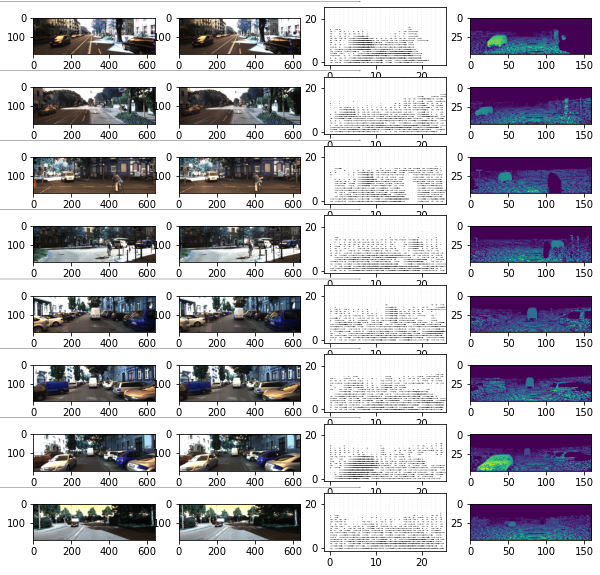

In [12]:
seq=sample[0][0]#[0]
flows=sample[1][1]#[0]
fig,axes=plt.subplots(nrows=len(seq),ncols=4,figsize=(10,10))
for i,[img,flow] in enumerate(zip(seq[:10],flows[:10])):
    axes[i,0].imshow(img[:,:,:3]+img_offset)
    axes[i,1].imshow(img[:,:,3:]+img_offset)
    _flow=cv2.resize(flow,(25,25))
    X = np.arange(0, 25, 1)
    Y = np.arange(0, 25, 1)
    _flow=np.flip(_flow,axis=0)
    U, V = _flow[:,:],_flow[:,:]*0
    q = axes[i,2].quiver(X, Y, U, V)
    axes[i,2].quiverkey(q, X=0.3, Y=1.1, U=10,label='', labelpos='E')
    axes[i,3].imshow(flow)
    #axes[i,2].imshow(_f_img)

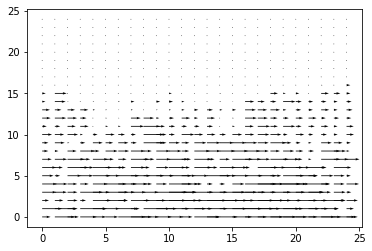

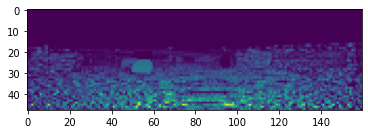

In [13]:
q = plt.quiver(X, Y, U, V)
plt.quiverkey(q, X=0.3, Y=1.1, U=100,label='Quiver key, length = 10', labelpos='E')
plt.show()
plt.imshow(flow)

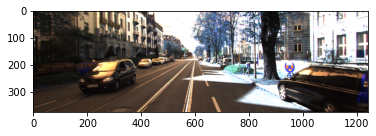

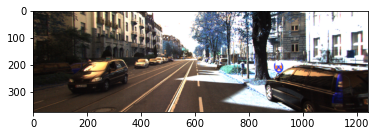

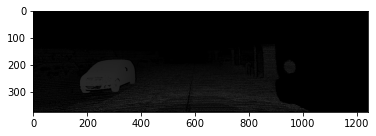

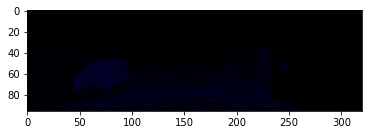

In [14]:
plt.imshow(cv2.imread(train_data[0][0]))
plt.show()
plt.imshow(cv2.imread(train_data[0][1]))
plt.show()
label=cv2.imread(train_label[0])
plt.imshow(label)
plt.show()
label=cv2.resize(label,(image_w//2,image_h//2))
label=cv2.cvtColor(label,cv2.COLOR_BGR2HSV)
label[:,:,1]=255
label=cv2.cvtColor(label,cv2.COLOR_HSV2BGR)
label=cv2.resize(label,(image_w//2,image_h//2))
plt.imshow(label)

In [15]:
def custom_loss_flow_mask(y_true, y_pred):
     
 
      y_true=tf.cast(y_true,tf.float32)
      y_pred=tf.cast(y_pred,tf.float32)
    
      mask= tf.cast((y_true>0.0),tf.float32)
      nf_mask= (mask*-1.0)+1.0#tf.to_float(y_true==0.0)
            
      loss=tf.square(tf.subtract(y_true,y_pred)*mask)
      loss=tf.sqrt(tf.reduce_mean(loss))
        
      nf_loss=tf.square(tf.subtract(y_true,y_pred)*nf_mask)
      nf_loss=tf.sqrt(tf.reduce_mean(nf_loss))
      
      return loss+ 0.1*nf_loss
    
def custom_loss_flow(y_true, y_pred):
      loss=tf.square(tf.subtract(y_true,y_pred))
      loss=tf.sqrt(tf.reduce_mean(loss))
      return loss

def custom_loss_pose_mask(y_true,y_pred):
    #if out_seq==True :
    loss_pos=tf.square(y_true[...,:3]-y_pred[...,:3])
    loss_ang=tf.square(y_true[...,3:]-y_pred[...,3:])*loss_beta
    loss=tf.concat([loss_pos,loss_ang],axis=-1)
    loss=loss[...,:]*loss_mask
    loss=tf.reduce_mean(loss,axis=-1)
    
    return loss

def custom_loss_pose_beta(y_true,y_pred):
    loss_trans=tf.keras.losses.MSE(y_true[...,0:3],y_pred[...,0:3])
    loss_rot=tf.keras.losses.MSE(y_true[...,3:6],y_pred[...,3:6])
    loss=loss_trans+loss_rot*loss_beta
    return loss

def custom_loss_trans(y_true,y_pred):
    loss_trans=tf.keras.losses.MAE(y_true,y_pred)
    return loss_trans

def custom_loss_rot(y_true,y_pred):
    loss_rot=tf.keras.losses.MAE(y_true,y_pred)
    #loss_rot=tf.sqrt(loss_rot)
    #loss_rot=tf.exp(loss_rot)
    if rot_loss_sqrt==True:
        loss_rot=tf.sqrt(loss_rot)
    return loss_rot

def mse(y_true, y_pred):
    rmse = K.mean(K.square((y_true - y_pred)))
    return rmse
def mse_trans(y_true, y_pred):
    rmse = K.mean(K.square((y_true[...,0:3] - y_pred[...,0:3])))
    return rmse
def mse_rot(y_true, y_pred):
    mse = K.mean(K.square((y_true[...,3:6] - y_pred[...,3:6])))
    rmse = tf.sqrt(mse)
    return rmse
def dummy_loss(y_true,y_pred):
    mse=K.mean(y_true-y_pred)*0.0
    return mse
N=64//scale
def _TDS(_layer):
    return _layer

if time_dis==True:
    TDS=TimeDistributed
else :
    TDS=_TDS
    


def DeepVO(x,classes=3,i=''):
    _convs=[]
    _par=_net_par
    for i in range(10):
        _name='block_'+str(_par._block[i])+'_conv_'+str(_par._nconv[i])
        x = TDS(Conv2D(_par._filters[i], (_par._kernels[i], _par._kernels[i]), padding='same',strides=_par._strides[i],kernel_regularizer=_par._kernel_regularizer,kernel_initializer=_par._kernel_initializer, name=_name))(x)
        if _par._batch_norm[i]: x = BatchNormalization()(x)
        if _par._act[i]==1:
                          if _par._leaky_relu==True: x = LeakyReLU(alpha=0.1)(x)
                          if _par._relu==True: x = ReLU()(x)
        if _par._drop_out[i]>0.0 : x = Dropout(_par._drop_out[i],seed=_par.drop_seed)(x)
        if _par._nconv[i]==2 or _par._block[i]==2: _convs.append(x)
    _conv=x
    x = TDS(Flatten())(x)
    #return x

    
    
    _convs=list(reversed(_convs[:-1]))#conv6_1,conv5_1,conv4_1,conv3_1,conv2_1
    flows=[]
    for i in range(4):

        conv_trans=Conv2DTranspose(_par._deconv_filters[i], (4,4), strides=(2, 2), padding='same', name='conv_trans_'+str(i))(_conv)
        if _par._deconv_act[i] :
            if _par._leaky_relu==True: conv_trans= LeakyReLU(alpha=0.1)(conv_trans)
            if _par._relu==True: conv_trans= ReLU()(conv_trans)
        flow = Conv2D(_par._deconv_chanel, (3, 3),  padding='same',strides=1, name='conv_flow'+str(i))(_conv)
        flow = Conv2DTranspose(_par._deconv_chanel, (4,4), strides=(2, 2), padding='same', name='flow_'+str(i))(flow)
        flows.append(flow)
        if i==-1: _conv = concatenate([_convs[i],conv_trans], axis = 3)
        else :   _conv = concatenate([_convs[i],conv_trans,flows[i]], axis = 3)
            
        
    i+=1
    flow = Conv2D(_par._deconv_chanel, (3, 3),  padding='same',strides=1, name='conv_flow'+str(i))(_conv)
    flow = Conv2DTranspose(_par._deconv_chanel, (4,4), strides=(2, 2), padding='same', name='flow_'+str(i))(flow)
    #flow=ReLU()(flow)
    flows.append(flow)
    flows=list(reversed(flows))
    
    #return flows,x
    return flows

loss_funcs_dict={
                 #'dummy_1': dummy_loss,
                 'flow_4':custom_loss_flow,
                 'flow_3':custom_loss_flow,
                 'flow_2':custom_loss_flow,
                 'flow_1':custom_loss_flow,
                 'flow_0':custom_loss_flow
} 
loss_weights_dict={
                   #'dummy_1':loss_weights[0],
                   'flow_4':loss_weights[0],
                   'flow_3':loss_weights[1],
                   'flow_2':loss_weights[2],
                   'flow_1':loss_weights[3],
                   'flow_0':loss_weights[4]
}

def Flow_Net(input_shape=(224,224,2)):
    _input=Input(shape=input_shape)
    #flows,x=DeepVO(_input,i=0)
    flows=DeepVO(_input,i=0)
    #x =Flatten()(x)
    #x =Dense(256,name='dummy_0')(x)
    #x =Dense(3,name='dummy_1')(x)
    #model = Model([_input],[x]+flows, name='vgg16')
    model = Model([_input],flows, name='vgg16')
    model.summary()
    return model

    
    
model = Flow_Net(input_shape=[image_h, image_w,6])
model.summary()

Model: "vgg16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 640, 6) 0                                            
__________________________________________________________________________________________________
block_1_conv_1 (Conv2D)         (None, 96, 320, 64)  18880       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 320, 64)  256         block_1_conv_1[0][0]             
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 96, 320, 64)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
import pickle
with open('D:\\KITTI\\weights\\flowNetS.pkl','rb') as file:
    flow_weights=pickle.load(file)
_flow_layer_names=list(flow_weights.keys())
_curr_layer_names=[]

curr_layer_names=[lyr.name for i,lyr in enumerate(model.layers) if lyr.name[:5]==str('block')]
flow_layer_names=[lyr for lyr in _flow_layer_names if lyr[:4]==str('conv')]
for _name,_fname in zip(curr_layer_names,flow_layer_names):
    layer=model.get_layer(_name)
    wts=tf.transpose(flow_weights[_fname][0],(2,3,1,0))
    bias=flow_weights[_fname][1]
    layer.set_weights([wts,bias])
    print(_name,'-',_fname,layer.weights[0].shape,wts.shape)

'''
curr_layer_names=[lyr.name for i,lyr in enumerate(model.layers) if lyr.name[:6]==str('conv_t')]
flow_layer_names=[lyr for lyr in _flow_layer_names if lyr[:6]==str('deconv')]
for _name,_fname in zip(curr_layer_names,flow_layer_names):
    layer=model.get_layer(_name)
    wts=tf.transpose(flow_weights[_fname][0],(2,3,1,0))
    bias=flow_weights[_fname][1]
    layer.set_weights([wts,bias])
    print(_name,'-',_fname,layer.weights[0].shape,wts.shape)


curr_layer_names=[lyr.name for i,lyr in enumerate(model.layers) if lyr.name[:4]==str('flow')]
flow_layer_names=[lyr for lyr in _flow_layer_names if lyr[:3]==str('ups')]
for _name,_fname in zip(curr_layer_names,flow_layer_names):
    layer=model.get_layer(_name)
    wts=tf.transpose(flow_weights[_fname][0],(2,3,1,0))
    bias=flow_weights[_fname][1]
    layer.set_weights([wts,bias])
    print(_name,'-',_fname,layer.weights[0].shape,wts.shape)
'''

block_1_conv_1 - conv1 (7, 7, 6, 64) (7, 7, 6, 64)
block_2_conv_1 - conv2 (5, 5, 64, 128) (5, 5, 64, 128)
block_3_conv_1 - conv3 (5, 5, 128, 256) (5, 5, 128, 256)
block_3_conv_2 - conv3_1 (3, 3, 256, 256) (3, 3, 256, 256)
block_4_conv_1 - conv4 (3, 3, 256, 512) (3, 3, 256, 512)
block_4_conv_2 - conv4_1 (3, 3, 512, 512) (3, 3, 512, 512)
block_5_conv_1 - conv5 (3, 3, 512, 512) (3, 3, 512, 512)
block_5_conv_2 - conv5_1 (3, 3, 512, 512) (3, 3, 512, 512)
block_6_conv_1 - conv6 (3, 3, 512, 1024) (3, 3, 512, 1024)
block_6_conv_2 - conv6_1 (3, 3, 1024, 1024) (3, 3, 1024, 1024)


"\ncurr_layer_names=[lyr.name for i,lyr in enumerate(model.layers) if lyr.name[:6]==str('conv_t')]\nflow_layer_names=[lyr for lyr in _flow_layer_names if lyr[:6]==str('deconv')]\nfor _name,_fname in zip(curr_layer_names,flow_layer_names):\n    layer=model.get_layer(_name)\n    wts=tf.transpose(flow_weights[_fname][0],(2,3,1,0))\n    bias=flow_weights[_fname][1]\n    layer.set_weights([wts,bias])\n    print(_name,'-',_fname,layer.weights[0].shape,wts.shape)\n\n\ncurr_layer_names=[lyr.name for i,lyr in enumerate(model.layers) if lyr.name[:4]==str('flow')]\nflow_layer_names=[lyr for lyr in _flow_layer_names if lyr[:3]==str('ups')]\nfor _name,_fname in zip(curr_layer_names,flow_layer_names):\n    layer=model.get_layer(_name)\n    wts=tf.transpose(flow_weights[_fname][0],(2,3,1,0))\n    bias=flow_weights[_fname][1]\n    layer.set_weights([wts,bias])\n    print(_name,'-',_fname,layer.weights[0].shape,wts.shape)\n"

In [17]:
if train==True:
    class loss_history(tf.keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.loss_items=['','flow_4','flow_3','flow_2','flow_1','flow_0']
            _loss_cols='epoch,'
            for _item in self.loss_items[:1]:
                _loss_cols+='train_loss,'
                _loss_cols+='val_loss,'
            for _item in self.loss_items[1:]:
                _loss_cols+=_item+'_loss,'
                _loss_cols+='val_'+_item+'_loss,'
            self.fe=open(log_dir+exp_name+'loss_epoch.csv','w+')
            self.fe.write(_loss_cols[:-1]+'\n')
            self.fe.close()
            self.losses = []
            self.val_losses = []
            self.epoch=1
        def on_epoch_begin(self, epoch, logs={}):
            self.epoch=start_epoch+epoch
        def on_batch_end(self, batch, logs={}):
            loss=logs.get('loss')
            val_loss=logs.get('val_loss')
            
            
        def on_epoch_end(self, epoch, logs={}):
            loss_str=str(self.epoch)+','
            for _item in self.loss_items[:1]:
                loss=logs.get(_item+'loss')
                val_loss=logs.get('val_'+_item+'loss')
                loss_str+=str(loss)+','+str(val_loss)+','
            for _item in self.loss_items[1:]:
                loss=logs.get(_item+'_loss')
                val_loss=logs.get('val_'+_item+'_loss')
                loss_str+=str(loss)+','+str(val_loss)+','
            self.fe=open(log_dir+exp_name+'loss_epoch.csv','a+')
            self.fe.write(loss_str[:-1]+'\n')
            self.fe.close()
            if (self.epoch)%200==0:
                model.save(log_dir+exp_name+str(self.epoch)+'.hdf5')
            if (self.epoch)%200==0:
                symbolic_weights = getattr(model.optimizer, 'weights')
                weight_values = K.batch_get_value(symbolic_weights)
                with open(log_dir+exp_name+str(self.epoch)+'.pkl', 'wb') as f:
                        pickle.dump(weight_values, f)
            #for i in range(20): 
            #    gc.collect()

            
    checkpoint = ModelCheckpoint(log_dir+exp_name+'best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint,loss_history()]
    model.compile(loss=loss_funcs_dict,loss_weights=loss_weights_dict, optimizer=opt)
    #history=model.fit_generator([train_data_a,train_data_b],train_label,batch_size=batch_size,validation_data=([val_data_a,val_data_b],val_label),epochs=10,)
    if pre_trained_wts_path !=None: 
        model.load_weights(pre_trained_wts_path)
    if pre_trained_opt_path !=None: 
        model._make_train_function()
        with open(pre_trained_opt_path, 'rb') as f:
            weight_values = pickle.load(f)
        model.optimizer.set_weights(weight_values)
    
    history=model.fit(train_batch,
                                validation_data=val_batch,
                                steps_per_epoch=len(train_data)//batch_size,
                                validation_steps=len(val_data)//batch_size,
                                epochs=epochs,
                                callbacks=callbacks_list
                                )
    

In [18]:
if train==True:
    from tensorflow.keras import backend as K
    model.save(log_dir+exp_name+str(epochs+start_epoch-1)+'_last.hdf5')
    symbolic_weights = getattr(model.optimizer, 'weights')
    weight_values = K.batch_get_value(symbolic_weights)
    with open(log_dir+exp_name+str(epochs+start_epoch-1)+'._last.pkl', 'wb') as f:
            pickle.dump(weight_values, f)
model.summary()

Model: "vgg16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 640, 6) 0                                            
__________________________________________________________________________________________________
block_1_conv_1 (Conv2D)         (None, 96, 320, 64)  18880       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 320, 64)  256         block_1_conv_1[0][0]             
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 96, 320, 64)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv_flow2 (Conv2D)             (None, 12, 40, 1)    6922        concatenate_1[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_12 (LeakyReLU)      (None, 24, 80, 128)  0           conv_trans_2[0][0]               
__________________________________________________________________________________________________
flow_2 (Conv2DTranspose)        (None, 24, 80, 1)    17          conv_flow2[0][0]                 
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 24, 80, 385)  0           leaky_re_lu_3[0][0]              
                                                                 leaky_re_lu_12[0][0]             
                                                                 flow_2[0][0]                     
__________

In [19]:
#model.save('deepvo_tds.h5')
if train==True:
    import pickle
    f=open(log_dir+exp_name+'train_hist.pkl','wb')
    pickle.dump([history.history['loss'],history.history['val_loss']],f)
    f.close()
    plt.plot(history.history['loss'][:])
    plt.savefig(log_dir+exp_name+'loss.png')
    plt.show()
    plt.plot(history.history['val_loss'][:])
    plt.savefig(log_dir+exp_name+'val_loss.png')
    plt.show()

In [20]:
from tqdm import trange
def test_model(model,epoch):
    R=np.zeros((1,no_of_pose))
    S=np.zeros((1,no_of_pose))
    _data=batch_generator(val_data,val_label)
    for i in trange(400):
        sample=next(_data)
        ret=model.predict(sample[0])
        _ret=np.concatenate(ret[0:2],axis=1)
        _sample=np.concatenate(sample[1][0:2],axis=1)
        
        R=np.concatenate((R,_ret[:,:]),axis=0)
        S=np.concatenate((S,_sample[:,:]),axis=0)
    _S=unscl_label(S)
    _R=unscl_label(R)
        
    f=open(log_dir+exp_name+str(epoch)+'temp_result.pkl','wb')
    pickle.dump([_S,_R,val_indx],f)
    f.close()

In [21]:
from tqdm import trange
batch_size=10
_data=batch_generator(train_data,train_label)
sample=next(_data)
model.load_weights(best_wts_path)
ret=model.predict(sample[0])

In [22]:
def get_depth(imgl,imgr):
    stereo = cv2.StereoBM_create(numDisparities=48, blockSize=25)
    stereo.setPreFilterSize(5)
    stereo.setPreFilterCap(1) 
    stereo.setTextureThreshold(5)
    stereo.setUniquenessRatio(5)
    stereo.setSpeckleWindowSize(0)
    stereo.setSpeckleRange(20)
    stereo.setDisp12MaxDiff(64)
                                 #)
    imgl=cv2.cvtColor(imgl,cv2.COLOR_BGR2GRAY)
    imgr=cv2.cvtColor(imgr,cv2.COLOR_BGR2GRAY)
    disp = stereo.compute(imgl,imgr)#/2032#+16
    disp = (disp+16.01)/768.01
    
    #depth= (focal_length*baseline)/(disp*image_w)
    #depth = np.clip(depth,1,10)
    ##depth = cv2.normalize(depth,None,4.5,6.5,cv2.NORM_MINMAX)
    #depth = cv2.resize(depth,(image_w//depth_scale,image_h//depth_scale))
    ##depth = np.clip(depth,0,1000)
    return disp

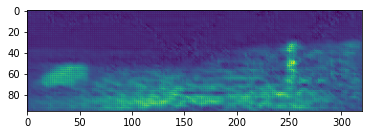

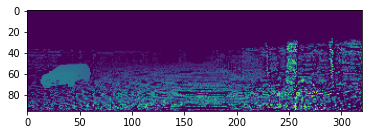

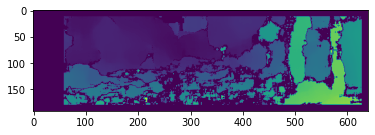

In [23]:

def unresize_scl(image,scl):
    of_img=cv2.resize(image,(image_w//scl,image_h//scl))
    temp=np.zeros((image_h//scl,image_w//scl,3),dtype=np.uint8)
    temp[:,:,0]=np.uint8(of_img[:,:,0]*180)
    temp[:,:,1]=200
    temp[:,:,2]=np.uint8(of_img[:,:,1]*255)
    temp=cv2.cvtColor(temp,cv2.COLOR_HSV2BGR)
    return temp
# 2 chanel,max 1 -> 2 chanel , max 255



#hsv[...,0] = ang*(180/np.pi/2)
#hsv[...,1] = 255
#hsv[...,2] = np.minimum(v*4, 255)
img=ret[0][1]
plt.imshow(img[:,:,0])
plt.show()

img=sample[1][0][1]
plt.imshow(img)
plt.show()
img=np.uint8(sample[0][0][1]*255)
disp=get_depth(img[:,:,:3]*255,img[:,:,3:]*255)
plt.imshow(disp)

In [24]:
sample[1][1][9].max(),ret[0].max()

(0.2127450980392157, 0.33671522)

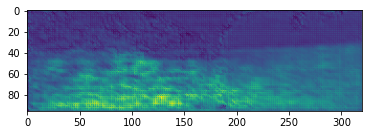

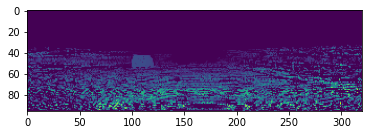

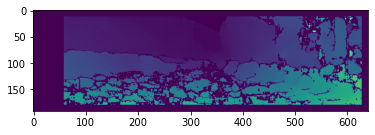

In [25]:
batch_size=10
_data=batch_generator(_val_data,_val_label)
sample=next(_data)
model.load_weights(best_wts_path)
ret=model.predict(sample[0])
ret[0][0]

img=ret[0][1][:,:,0]
plt.imshow(img)
plt.show()
img=sample[1][0][1]
plt.imshow(img)
plt.show()
img=np.uint8(sample[0][0][1]*255)
disp=get_depth(img[:,:,:3]*255,img[:,:,3:]*255)
plt.imshow(disp)

In [26]:
sample[0][0].shape

(10, 192, 640, 6)

In [27]:
_data=batch_generator(_train_data,_train_label)
sample=next(_data)

In [28]:
from tqdm import tqdm
train_files=[0,1,2,3,6,8,9]
val_files=[4,5,7,10]#7,10]
test_files=[4,5,7,10]
time_step=2
overlap=1
start_points=[0]

In [29]:
def get_disp_path(_path):
        _path=_path.replace('sequences','disp')
        _path=_path.replace('png','disp')
        _path=_path.replace('\\image_2','')
        return _path

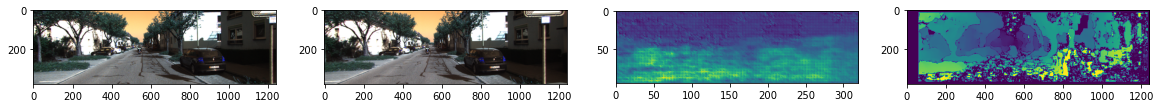

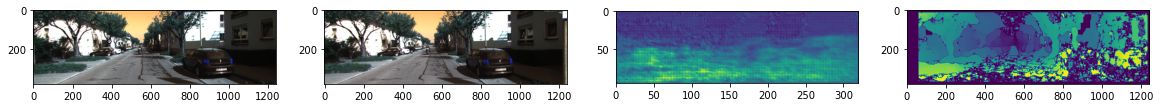

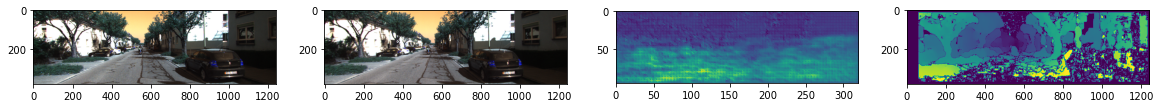

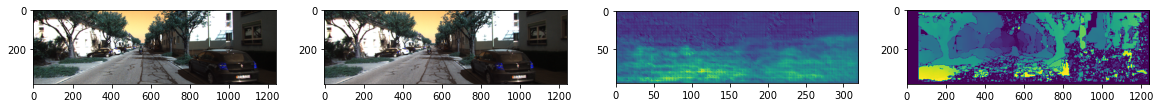

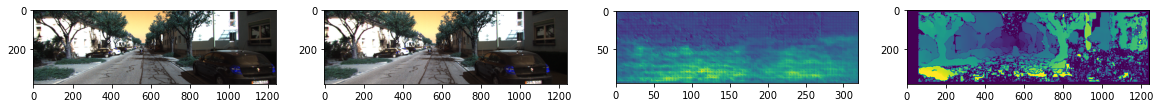

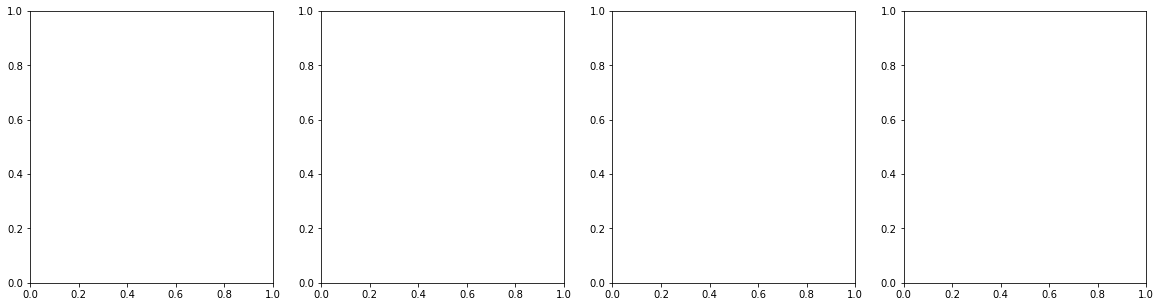

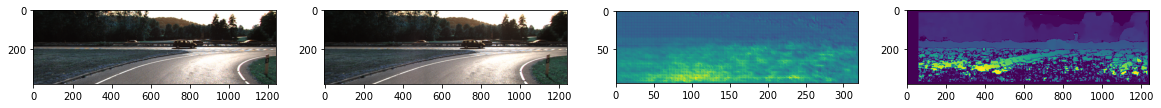

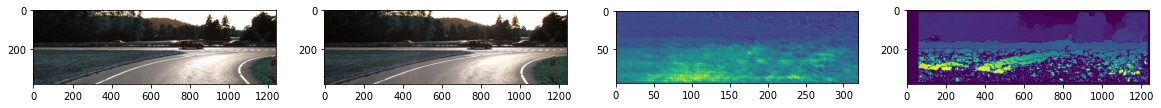

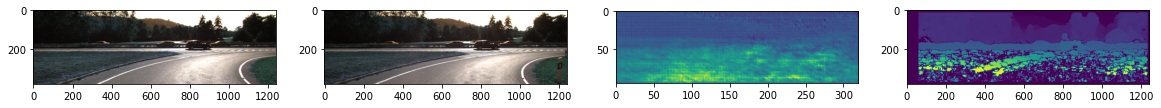

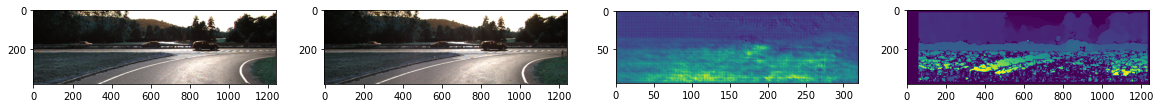

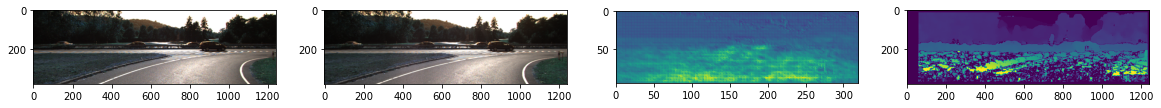

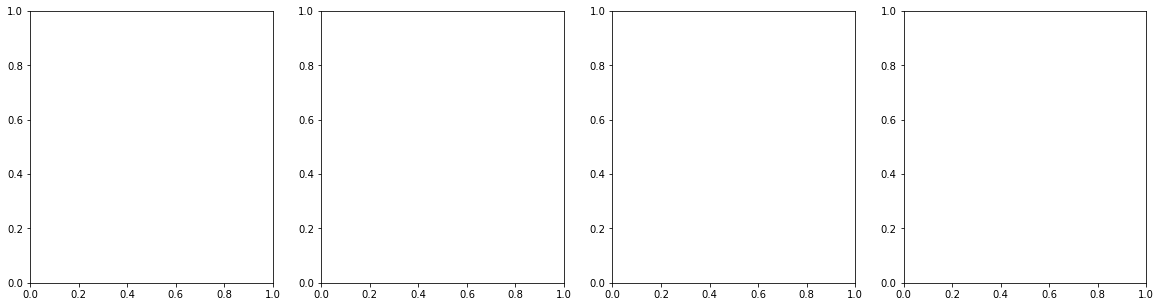

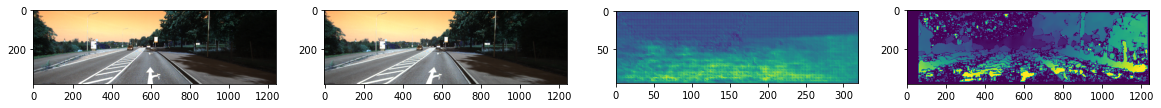

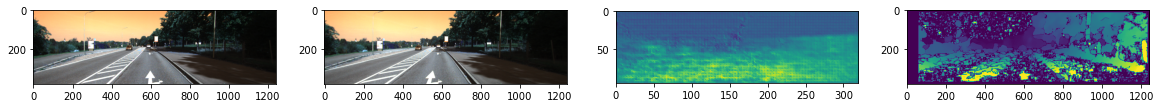

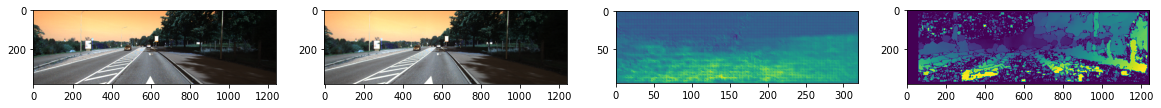

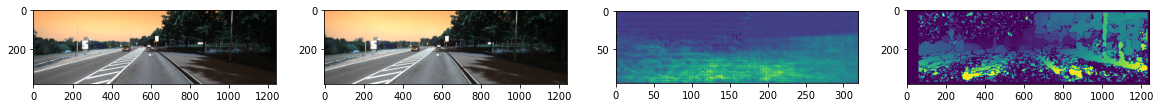

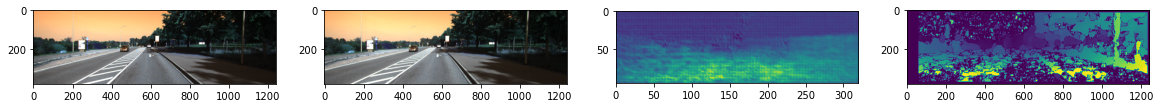

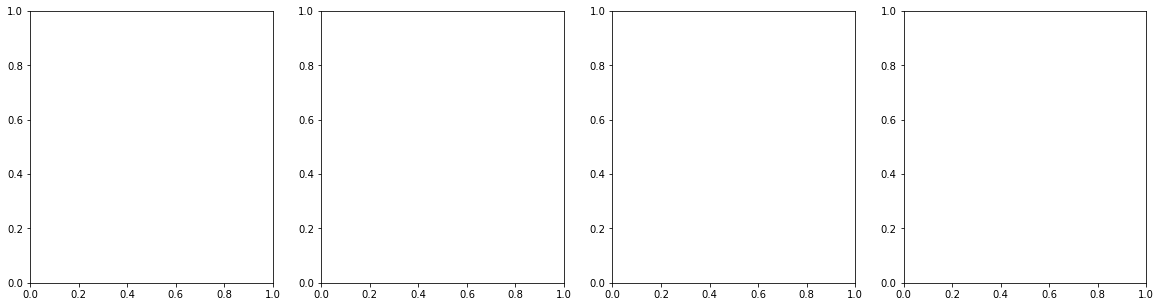

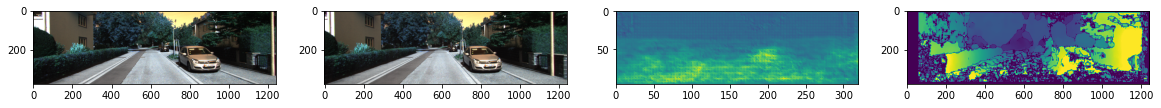

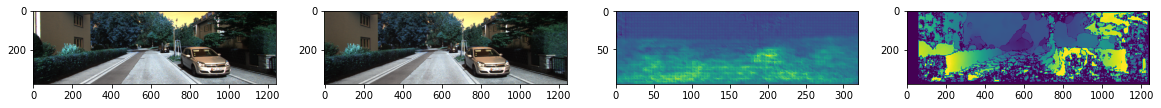

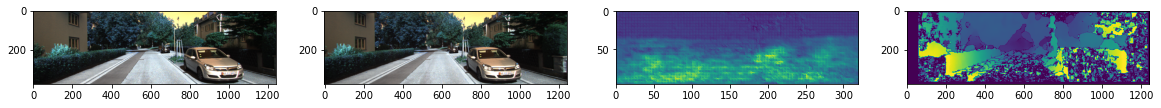

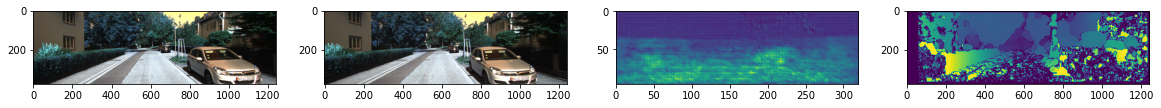

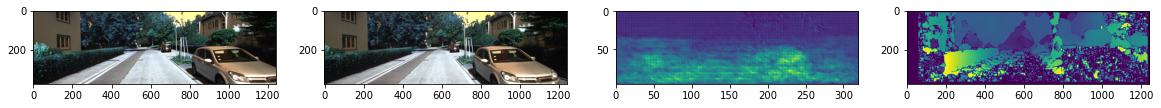

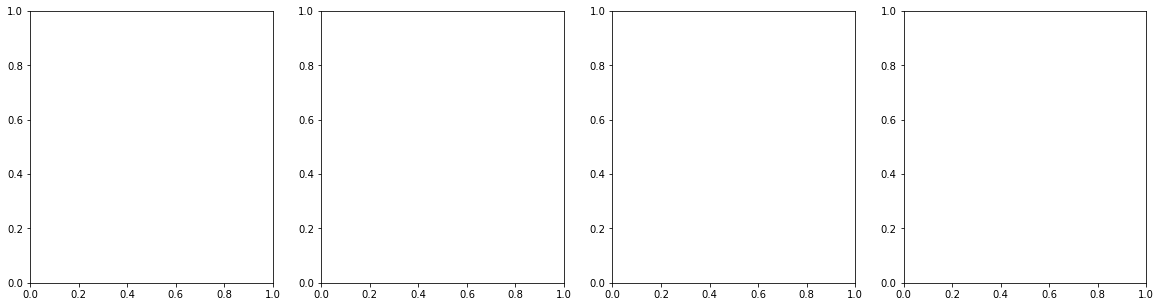

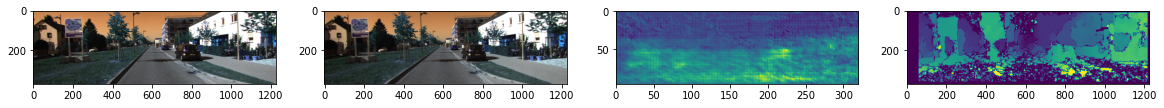

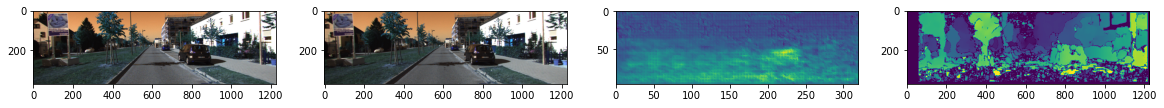

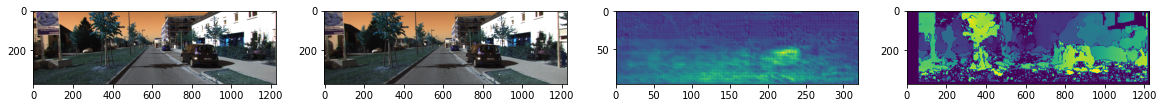

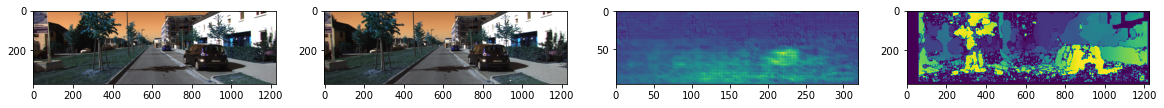

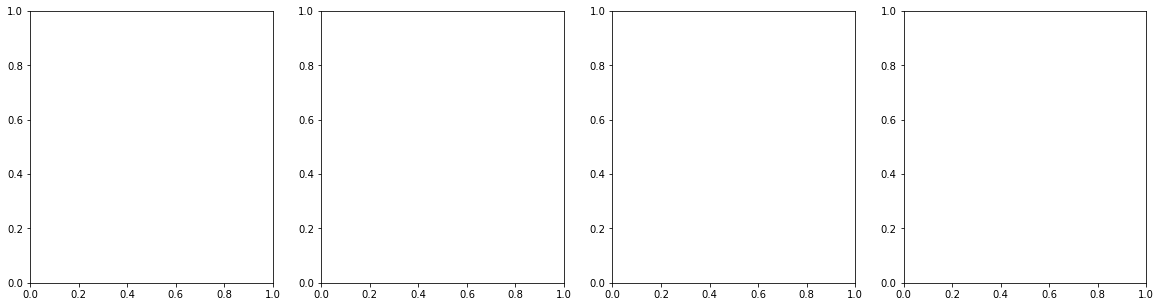

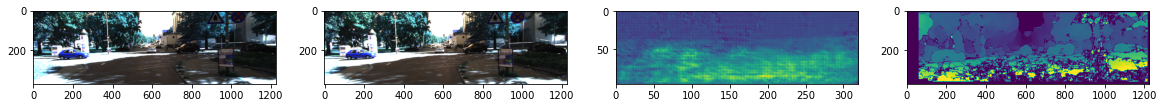

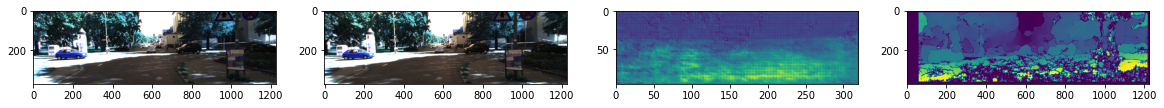

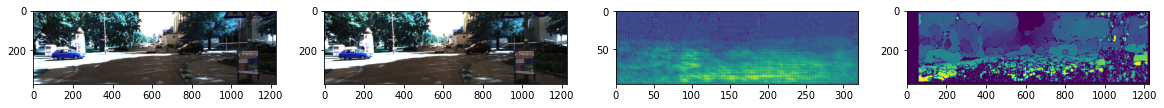

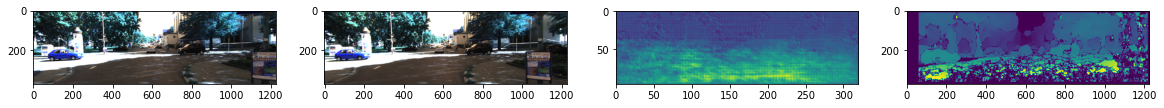

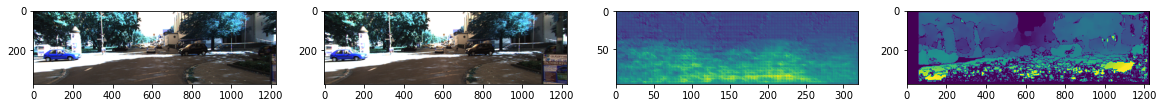

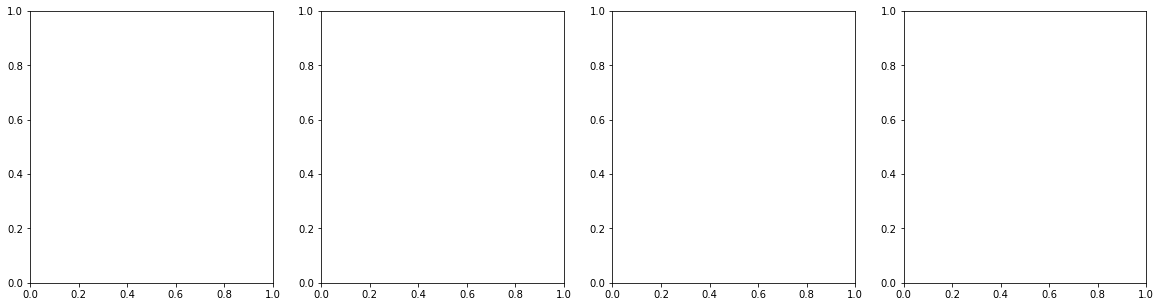

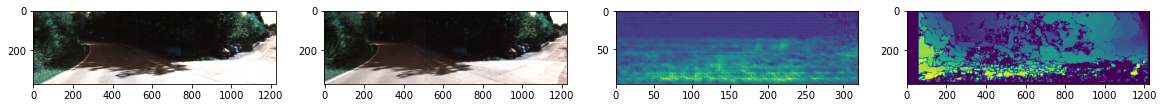

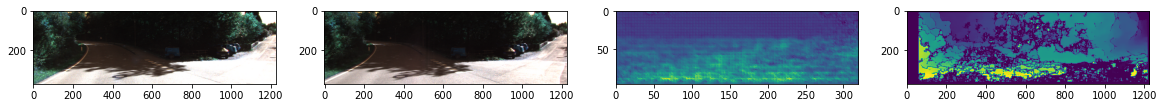

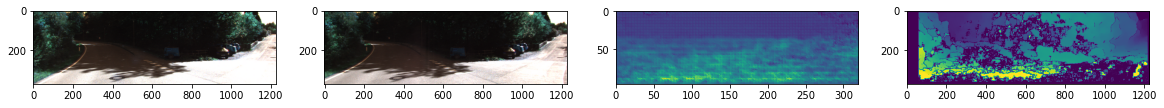

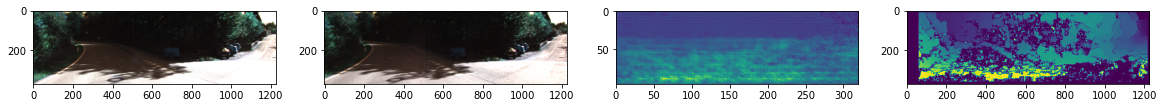

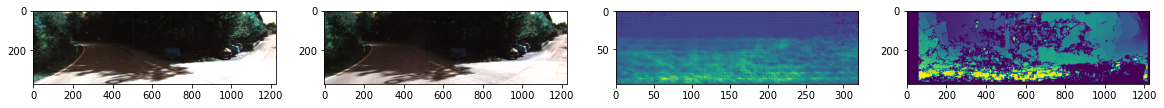

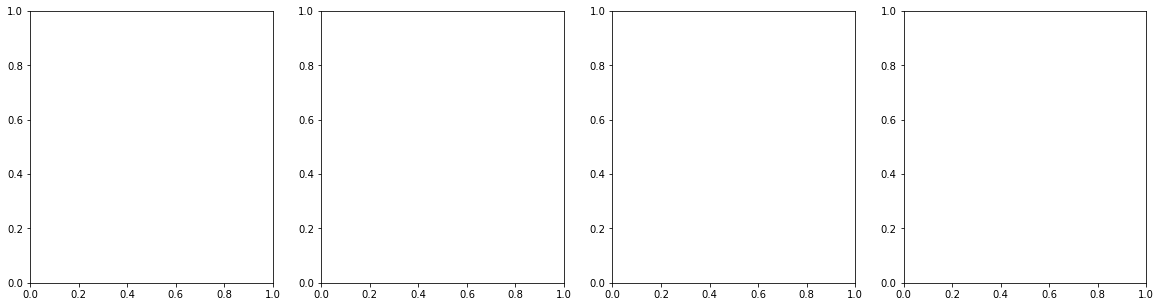

In [30]:


def test_predicted_flow(img_root,_files):
    img_root_ext='\\image_2\\*'
    X = np.arange(0, 25, 1)
    Y = np.arange(0, 25, 1)
    for i in _files:
           img_data_a=[]
           _input=np.zeros((1,image_h,image_w,6),np.float64)
           for i,path in enumerate(glob.glob(img_root+str(i).zfill(2)+img_root_ext)):
                 fig,axes=plt.subplots(nrows=1,ncols=4,figsize=(20,5))
                 img_a=cv2.imread(path)
                 img_b=cv2.imread(path.replace("image_2","image_3"))
                 _input[0,:,:,:3]= cv2.resize((img_a/255.0)-0.5,(image_w,image_h))
                 _input[0,:,:,3:]= cv2.resize((img_b/255.0)-0.5,(image_w,image_h))
                 disp_1=model.predict(_input)[0][0][:,:,0]
                 disp_2=get_depth(img_a,img_b)
                 #flow=get_flow_img(img_a,img_b)/128.0

                 if i < 5:
                     axes[0].imshow(img_a)
                     axes[1].imshow(img_b)
                     axes[2].imshow(disp_1)
                     axes[3].imshow(disp_2)
                     plt.show()
                 else :
                    break
                    
                    
    return np.array(disp_1)

model.load_weights(best_wts_path)
_out=test_predicted_flow(img_root_test,train_files)

In [31]:
def get_image_paths(img_root1,_files,_overlap=1):
    img_data_a=[]
    img_data_b=[]
    img_root2='\\image_2\\*'
    for i in _files:
        for path in glob.glob(img_root1+str(i).zfill(2)+img_root2)[:-1]:
            img_data_a.append([path,path.replace('image_2','image_3')])
    return np.array(img_data_a)

train_data=get_image_paths(img_root_test,train_files,_overlap=overlap)
val_data=get_image_paths(img_root_test,val_files,_overlap=overlap)
#test_data=get_image_paths(img_root,test_files,_overlap=(time_step-1))
model.load_weights(best_wts_path)

if _gen_disp==True:
    try : os.mkdir(disp_save_root)
    except:print('dir_exists')
    for file in train_files+val_files:
        try:os.mkdir(disp_save_root+str(file).zfill(2))
        except:print(disp_save_root+str(file).zfill(2),'paths exists')

    for path in tqdm(np.concatenate([train_data,val_data])):
                _input=np.zeros((1,image_h,image_w,6),np.float64)
                img_a=cv2.resize(cv2.imread(path[0]),(image_w,image_h))
                img_b=cv2.resize(cv2.imread(path[1]),(image_w,image_h))
                #_input[0,:,:,:3]= cv2.resize((img_a/255.0)-0.5,(image_w,image_h))
                #_input[0,:,:,3:]= cv2.resize((img_b/255.0)-0.5,(image_w,image_h))
                #disp_img=model.predict(_input)[0][0]
                disp_img=get_depth(img_a,img_b)
                disp_img=cv2.resize(disp_img,(image_w//of_scale,image_h//of_scale))
                disp_path=get_disp_path(path[0])
                with open(disp_path,'wb') as file:
                     pickle.dump(disp_img,file)

  0%|                                                                                | 4/23190 [00:00<12:08, 31.83it/s]

dir_exists
D:\KITTI\data_odometry_color\dataset\disp\00 paths exists
D:\KITTI\data_odometry_color\dataset\disp\01 paths exists
D:\KITTI\data_odometry_color\dataset\disp\02 paths exists
D:\KITTI\data_odometry_color\dataset\disp\03 paths exists
D:\KITTI\data_odometry_color\dataset\disp\06 paths exists
D:\KITTI\data_odometry_color\dataset\disp\08 paths exists
D:\KITTI\data_odometry_color\dataset\disp\09 paths exists
D:\KITTI\data_odometry_color\dataset\disp\04 paths exists
D:\KITTI\data_odometry_color\dataset\disp\05 paths exists
D:\KITTI\data_odometry_color\dataset\disp\07 paths exists
D:\KITTI\data_odometry_color\dataset\disp\10 paths exists


100%|████████████████████████████████████████████████████████████████████████████| 23190/23190 [12:50<00:00, 30.11it/s]


# 